In [1]:
%reload_ext autoreload
%autoreload 2

import torch

torch.manual_seed(42)


In [2]:
from data.names_data_source import NamesDataSource
from data.tokenizer import Tokenizer


names_data_source = NamesDataSource.load(
    data_folder="../../../../datasets/names",
    normalize_unicode=True,
)

tokenizer = Tokenizer(use_start_token=True, use_end_token=True)
tokenizer.load(names_data_source.vocab)


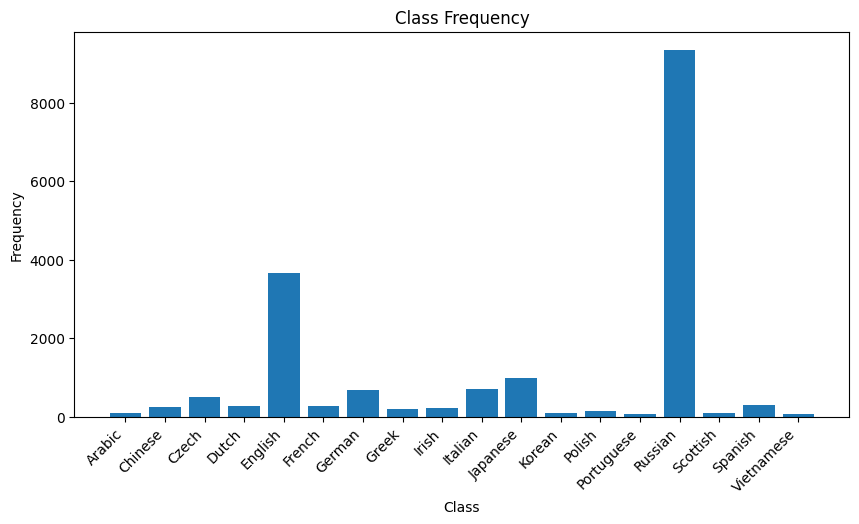

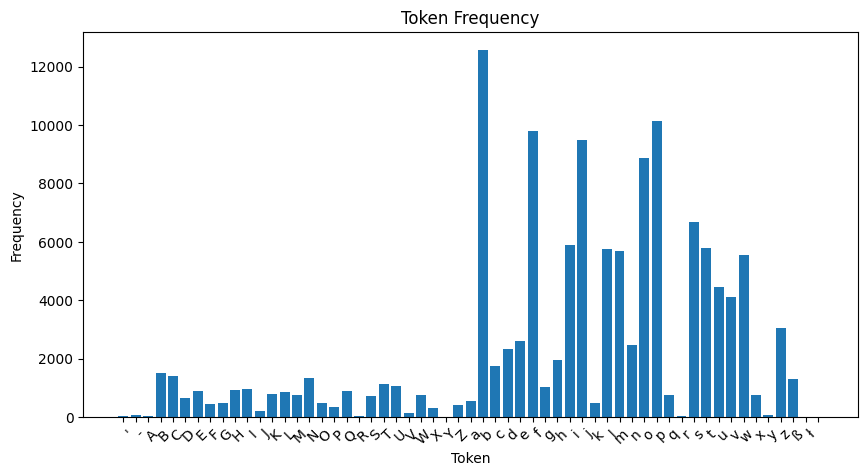

In [3]:
names_data_source.plot_class_frequency((10, 5))
names_data_source.plot_token_frequency((10, 5))

In [4]:
from learning.names_generator.model import Config

config = Config(
    batch_size=2**10,
    learning_rate=1e-3,
    epochs=1,
    patience=30,
    min_delta=1e-4,
    hidden_size=128,
    num_vocab=tokenizer.vocab_size,
    num_classes=names_data_source.num_classes,
    device=torch.device("cpu"),
)

torch.set_float32_matmul_precision("medium")


In [5]:
import torch
from learning.names_generator.names_generator_dataset import NamesGeneratorDataset


names_dataset = NamesGeneratorDataset(
    names_data_source,
    tokenizer,
    device=config.device,
)
sample = names_dataset[0]
print(sample)


NameSample(input=tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.

In [6]:
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    names_dataset, [0.80, 0.10, 0.10]
)
print(f"Train dataset size: {len(train_dataset)}")
print(f"Val dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


Train dataset size: 14395
Val dataset size: 1799
Test dataset size: 1799


In [7]:
from learning.names_generator.model import NamesGenerator
import torch
import torch.nn as nn


def generate_name(model: NamesGenerator, country_idx: int):
    with torch.no_grad():
        # shape: [1, C]
        category_tensor = names_dataset.country_index_to_one_hot(country_idx).unsqueeze(
            0
        )

        # shape: [1, H]
        hidden_tensor = model.init_hidden()

        # shape: [1, V]
        input_tensor = tokenizer.to_one_hot(Tokenizer.START_TOKEN, device=config.device)

        output_names = []
        for i in range(50):
            # shape: [1, V]
            output, hidden_tensor = model(category_tensor, input_tensor, hidden_tensor)

            probs = torch.exp(output)
            idx = int(torch.multinomial(probs, num_samples=1).item())

            if tokenizer.is_special_idx(idx):
                break

            next_char = tokenizer.index_to_token[idx]
            output_names.append(next_char)
            input_tensor = tokenizer.to_one_hot(next_char)

        return "".join(output_names)


test_names_generator = NamesGenerator(
    hidden_size=128,
    num_vocab=tokenizer.vocab_size,
    num_classes=names_data_source.num_classes,
)
for _ in range(10):
    print(generate_name(test_names_generator, 4))


akGgesYvnuQSDLELbßłJOxJIYTjB Qk-hbwmsPaF
k Q NxvV
lZs'wA-irbjGlldMDiawkqgt
FMvuTfDßVYgvKßQZrOtya
yQWm'
lDJw'mtE
DKOkEySyhpCYpEz
AycRgk-iEmłOn

SA PVRp-Q


In [8]:
import time
import math
import torch
from learning.names_generator.model import (
    Batch,
    ParallelBatchLearner,
    NamesGenerator,
)
from learning.metrics import (
    ConfusionMatrixMetric,
)

from torch.utils.data import DataLoader

model = NamesGenerator(
    num_classes=names_data_source.num_classes,
    num_vocab=tokenizer.vocab_size,
    hidden_size=config.hidden_size,
)
print(model)
pad_token_idx = tokenizer.token_to_index[Tokenizer.PAD_TOKEN]
criterion = nn.CrossEntropyLoss(reduction="sum", ignore_index=pad_token_idx)
print(criterion)
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
print(optimizer)

learner = ParallelBatchLearner(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    padding_idx=pad_token_idx,
    device=config.device,
)
print(learner)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    collate_fn=Batch.from_samples,
)

eval_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    collate_fn=Batch.from_samples,
)

train_confusion_matrix_metric = ConfusionMatrixMetric(classes=tokenizer.index_to_token)
eval_confusion_matrix_metric = ConfusionMatrixMetric(classes=tokenizer.index_to_token)

print(
    "Starting training...\n"
    f"Expecting initial loss around {math.log(tokenizer.vocab_size)}"
)
start_time = time.time()
train_losses, eval_losses = learner.fit(
    train_dataloader=train_dataloader,
    eval_dataloader=eval_dataloader,
    num_epochs=config.epochs,
    patience=config.patience,
    min_delta=config.min_delta,
    train_metrics=[train_confusion_matrix_metric],
    eval_metrics=[eval_confusion_matrix_metric],
)
elapsed_time = time.time() - start_time
print(f"Training completed. Elapsed time: {elapsed_time:.2f}s")


NamesGenerator(
  (i2h): MLP(
    (norm): LayerNorm((206,), eps=1e-05, elementwise_affine=True)
    (fc): Linear(in_features=206, out_features=128, bias=True)
    (gelu): GELU(approximate='none')
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (i2o): MLP(
    (norm): LayerNorm((206,), eps=1e-05, elementwise_affine=True)
    (fc): Linear(in_features=206, out_features=60, bias=True)
    (gelu): GELU(approximate='none')
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (o2o): MLP(
    (norm): LayerNorm((188,), eps=1e-05, elementwise_affine=True)
    (fc): Linear(in_features=188, out_features=60, bias=True)
    (gelu): GELU(approximate='none')
    (dropout): Dropout(p=0.2, inplace=False)
  )
)
CrossEntropyLoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
ParallelBatchLearner
mo

### RESEARCH LOG

In DESC ordering

#### Experiment 4

```
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
HIDDEN_SIZE = 256
NUM_EPOCHS = 500
PATIENCE = 10
```

Result:
- 27/500 -- 3.50s 	Train loss 	1.9281 	Eval loss 	2.1096 	
- Training completed. Elapsed time: 96.83s

#### Experiment 3
Add LayerNorm
```
NamesGenerator(
  (i2h): Linear(in_features=334, out_features=256, bias=True)
  (i2h_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (i2h_gelu): GELU(approximate='none')
  (i2o): Linear(in_features=334, out_features=60, bias=True)
  (i2o_layer_norm): LayerNorm((60,), eps=1e-05, elementwise_affine=True)
  (i2o_gelu): GELU(approximate='none')
  (o2o): Linear(in_features=316, out_features=60, bias=True)
  (o2o_layer_norm): LayerNorm((60,), eps=1e-05, elementwise_affine=True)
  (o2o_gelu): GELU(approximate='none')
  (dropout): Dropout(p=0.1, inplace=False)
)
```
Result:
- 70/500 -- 3.57s 	Train loss 	2.1711 	Eval loss 	2.2408 	
- Training completed. Elapsed time: 251.79s
- Gets to similar result in about half the time.

#### Experiment 2
Added GELU
```
NamesGenerator(
  (i2h): Linear(in_features=334, out_features=256, bias=True)
  (i2h_gelu): GELU(approximate='none')
  (i2o): Linear(in_features=334, out_features=60, bias=True)
  (i2o_gelu): GELU(approximate='none')
  (o2o): Linear(in_features=316, out_features=60, bias=True)
  (o2o_gelu): GELU(approximate='none')
  (dropout): Dropout(p=0.1, inplace=False)
)
```
Result
- 223/500 -- 2.11s 	Train loss 	2.1839 	Eval loss 	2.1243 	
- Training completed. Elapsed time: 473.82s
- Slightly better result. The network seems to stop learning. Grad becomes too small at the end

#### Experiment 1
```
BATCH_SIZE = 64
LEARNING_RATE = 1e-4
HIDDEN_SIZE = 256
NUM_EPOCHS = 500
PATIENCE = 10
```
Result:
- 130/500 -- 1.71s 	Train loss 	2.2599 	Eval loss 	2.1352 	
- Training completed. Elapsed time: 223.06s

In [9]:
for _ in range(10):
    print(generate_name(model, 4))


waButO
XrudeRv
lXke
PeDJn
WZtPvn
KeJrorr
Mohradu
Rkigeiin
B
mawePss


['<|pad|>', '<|start|>', '<|end|>', ' ', "'", '-', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'ß', 'ł']


Text(0.5, 1.0, 'F1 Score')

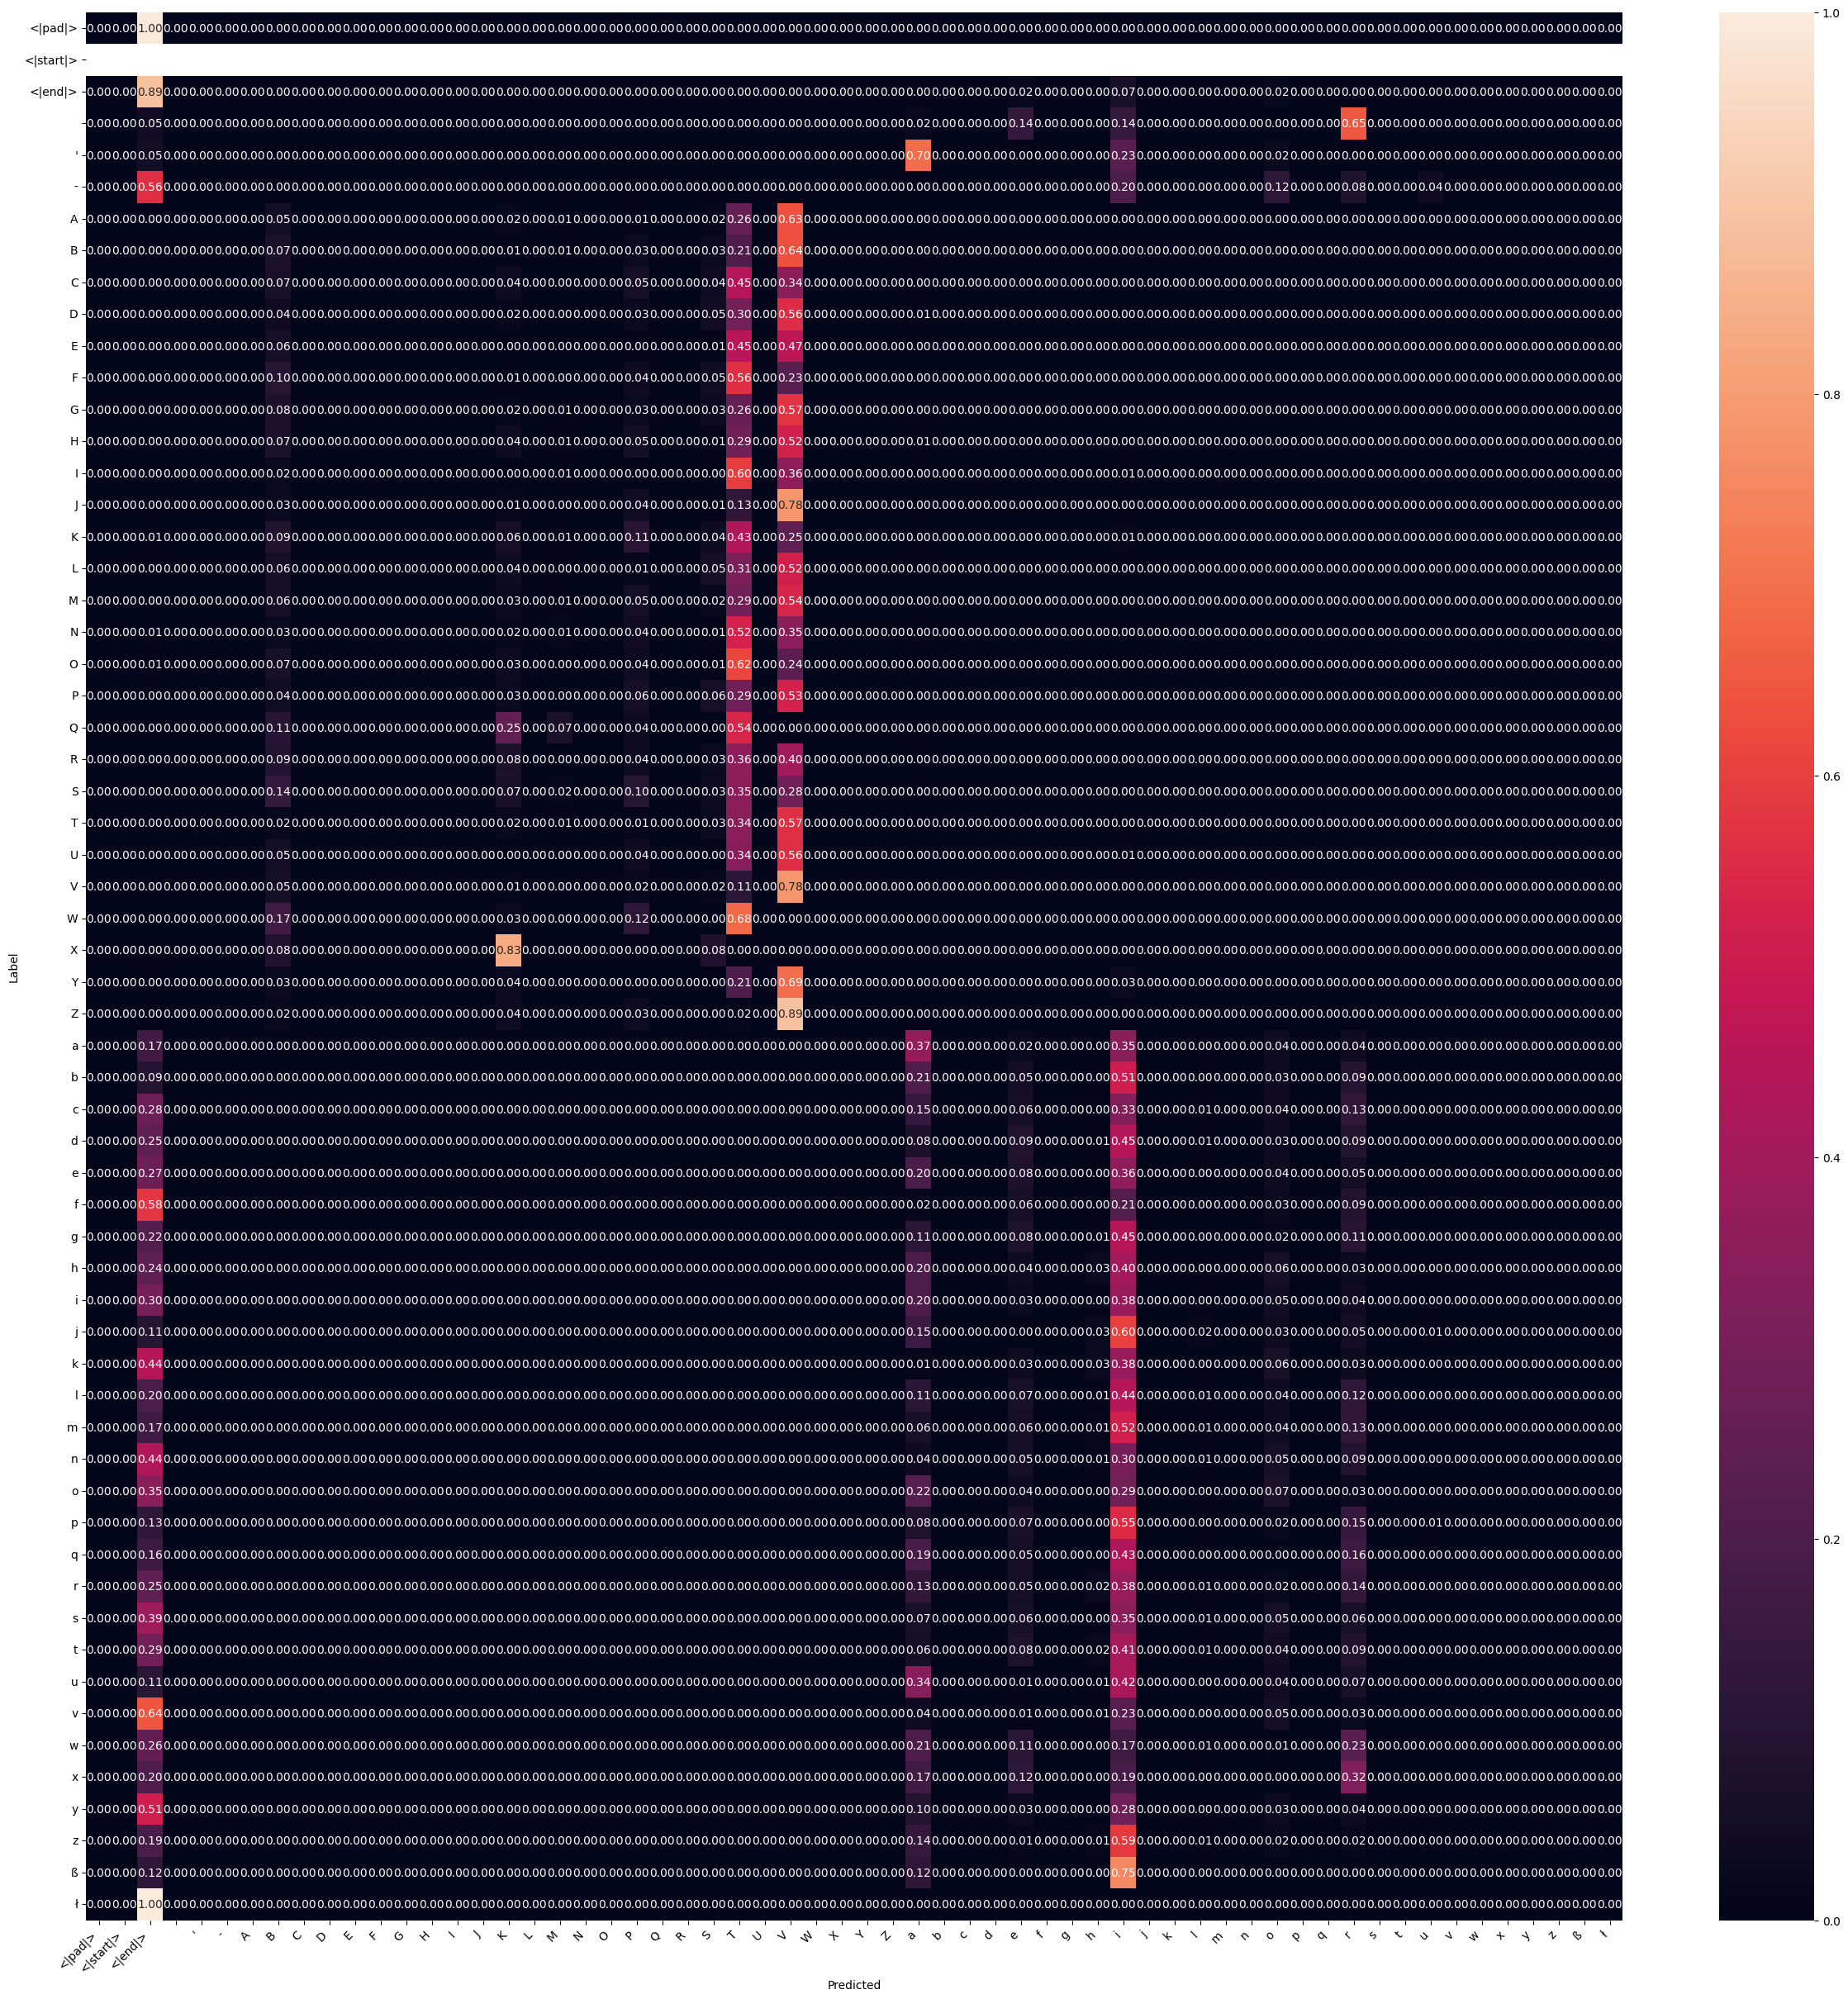

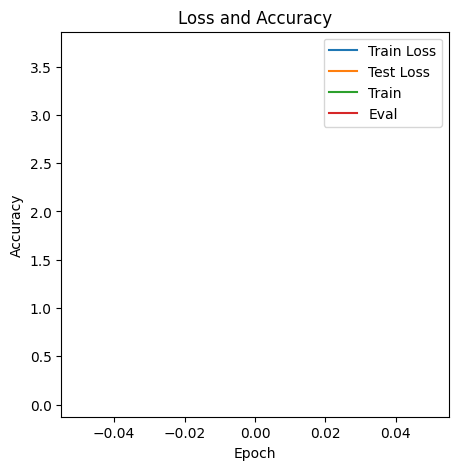

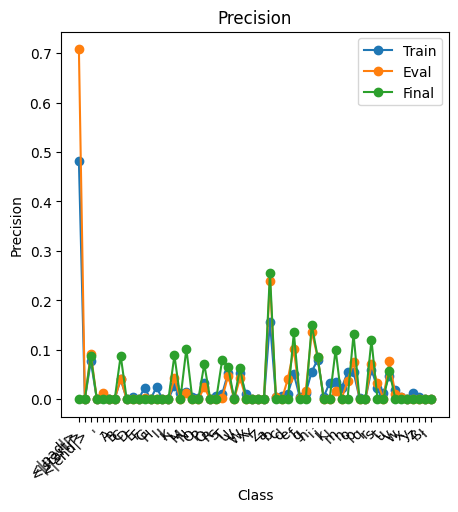

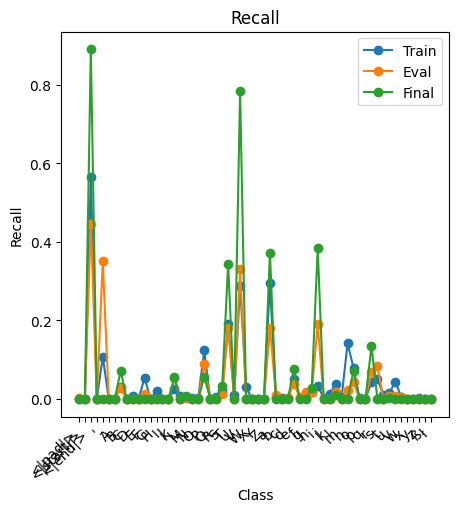

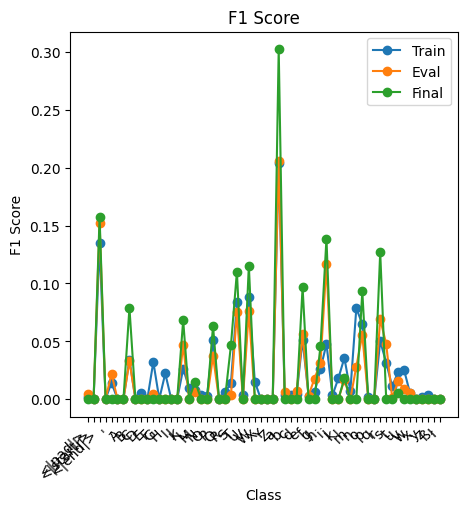

In [10]:
import matplotlib.pyplot as plt

print(tokenizer.index_to_token)

full_dataloader = DataLoader(
    dataset=names_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    collate_fn=Batch.from_samples,
)
full_confusion_matrix_metric = ConfusionMatrixMetric(classes=tokenizer.index_to_token)
final_loss = learner.final_eval(
    dataloader=full_dataloader, metrics=[full_confusion_matrix_metric]
)

_, ax = plt.subplots(figsize=(30, 30))
full_confusion_matrix_metric.plot_confusion_matrix(ax, normalize=True)

_, ax = plt.subplots(figsize=(5, 5))
ax.plot(train_losses, label="Train Loss")
ax.plot(eval_losses, label="Test Loss")
train_confusion_matrix_metric.plot_accuracies(ax, "Train")
eval_confusion_matrix_metric.plot_accuracies(ax, "Eval")
ax.set_title("Loss and Accuracy")

_, ax = plt.subplots(figsize=(5, 5))
train_confusion_matrix_metric.plot_class_precisions(ax, "Train")
eval_confusion_matrix_metric.plot_class_precisions(ax, "Eval")
full_confusion_matrix_metric.plot_class_precisions(ax, "Final")
ax.set_title("Precision")

_, ax = plt.subplots(figsize=(5, 5))
train_confusion_matrix_metric.plot_class_recalls(ax, "Train")
eval_confusion_matrix_metric.plot_class_recalls(ax, "Eval")
full_confusion_matrix_metric.plot_class_recalls(ax, "Final")
ax.set_title("Recall")

_, ax = plt.subplots(figsize=(5, 5))
train_confusion_matrix_metric.plot_class_f1_scores(ax, "Train")
eval_confusion_matrix_metric.plot_class_f1_scores(ax, "Eval")
full_confusion_matrix_metric.plot_class_f1_scores(ax, "Final")
ax.set_title("F1 Score")


NamesGenerator(
  (i2h): MLP(
    (norm): LayerNorm((206,), eps=1e-05, elementwise_affine=True)
    (fc): Linear(in_features=206, out_features=128, bias=True)
    (gelu): GELU(approximate='none')
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (i2o): MLP(
    (norm): LayerNorm((206,), eps=1e-05, elementwise_affine=True)
    (fc): Linear(in_features=206, out_features=60, bias=True)
    (gelu): GELU(approximate='none')
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (o2o): MLP(
    (norm): LayerNorm((188,), eps=1e-05, elementwise_affine=True)
    (fc): Linear(in_features=188, out_features=60, bias=True)
    (gelu): GELU(approximate='none')
    (dropout): Dropout(p=0.2, inplace=False)
  )
)


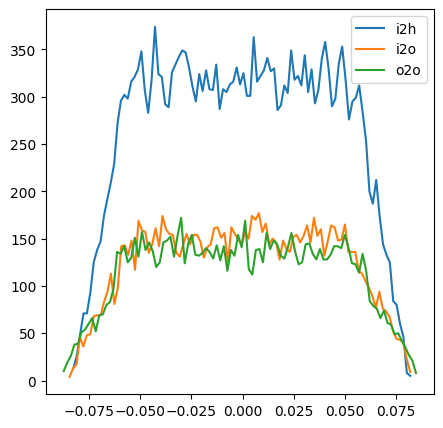

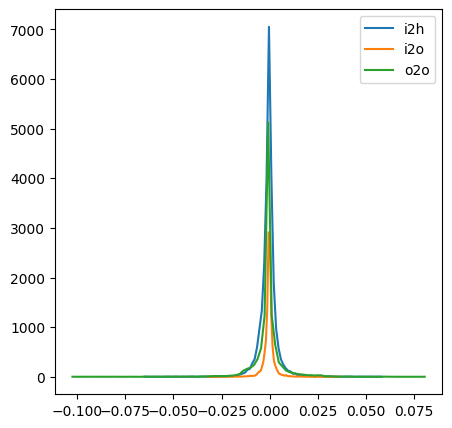

In [11]:
print(model)

with torch.no_grad():
    i2h_hist, i2h_edges = torch.histogram(model.i2h.fc.weight)
    i2o_hist, i2o_edges = torch.histogram(model.i2o.fc.weight)
    o2o_hist, o2o_edges = torch.histogram(model.o2o.fc.weight)

    f, ax = plt.subplots(figsize=(5, 5))
    ax.plot(i2h_edges[:-1], i2h_hist, label="i2h")
    ax.plot(i2o_edges[:-1], i2o_hist, label="i2o")
    ax.plot(o2o_edges[:-1], o2o_hist, label="o2o")
    ax.legend()

with torch.no_grad():
    i2h_hist, i2h_edges = torch.histogram(model.i2h.fc.weight.grad)
    i2o_hist, i2o_edges = torch.histogram(model.i2o.fc.weight.grad)
    o2o_hist, o2o_edges = torch.histogram(model.o2o.fc.weight.grad)

    f, ax = plt.subplots(figsize=(5, 5))
    ax.plot(i2h_edges[:-1], i2h_hist, label="i2h")
    ax.plot(i2o_edges[:-1], i2o_hist, label="i2o")
    ax.plot(o2o_edges[:-1], o2o_hist, label="o2o")
    ax.legend()